In [1]:
import os
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dask.dataframe as dd
from tensorflow import keras
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.python.client import device_lib
from matplotlib import font_manager, rc, dates
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

In [2]:
print(tf.__version__)
print(device_lib.list_local_devices())

2.8.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13908743647378736339
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3667263488
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2119730541473671767
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [3]:
def reward_co2(co2):
    reward = np.exp(-((co2-900)**2)/(2*350**2))
    return reward


def reward_heat(temp):
    reward = np.exp(-((temp-29)**2)/(2*2**2))
    return reward

* 학습용 데이터셋 준비(솜사탕)
* 거실만사용
* 환기, 보일러작동 2개로 멀티에이전트 학습

In [4]:
## 불러오기 ##
path = os.getcwd()
site_list = sorted(glob(os.path.join(path,"data","sensing_data","*")))
site_list = list(map(os.path.basename,site_list))
print(path)
print(site_list)
site = "솜사탕"
time_mean = "5T"
csv_by_site_det = []


structure = sorted(glob(os.path.join(path,"data","sensing_data",site,'*')))
structure = list(map(os.path.basename,structure))
for j in structure:
        temp_data = dd.read_csv(os.path.join(path,"data","sensing_data",site,j),encoding='cp949').compute()
        temp_data['T/D'] = pd.to_datetime(temp_data['T/D'])
       
        temp_data.set_index('T/D',inplace=True)
        temp_data = temp_data.resample(time_mean,).mean()
        temp_data['site_details'] = j
        csv_by_site_det.append(temp_data)

data = pd.concat(csv_by_site_det)
data.columns = ['index','temp','hum','pm1','pm2.5','pm4','pm10','co2','tvoc','site_details']
data = data[['temp','hum','pm1','pm2.5','pm4','pm10','co2','tvoc','site_details']]
## 라벨링 ##

data['vent'] = 0
data['people'] = 0
data['heat'] = 0


data.loc[data.between_time('12:00:00', '18:00:00',include_end=False).index,['vent']] = 1
data.loc[data.between_time('9:00:00', '16:00:00',include_end=False).index,['people']] = 1
data.loc[data.between_time('10:00:00', '14:00:00',include_end=False).index,['heat']] = 1

#0부터 월요일
data.loc[data[data.index.dayofweek == 5].index,['vent']] = 0
data.loc[data[data.index.dayofweek == 5].index,['people']] = 0
data.loc[data[data.index.dayofweek == 5].index,['heat']] = 0

data.loc[data[data.index.dayofweek == 6].index,['vent']] = 0
data.loc[data[data.index.dayofweek == 6].index,['people']] = 0
data.loc[data[data.index.dayofweek == 6].index,['heat']] = 0



c:\Users\Go\OneDrive - UOS\allrepos\multi_agent_awac
['남부', '동화나라', '소리엘', '솜사탕', '예나']


C:\Users\Go\AppData\Local\Temp\ipykernel_11536\3654965324.py:33: FutureWarning: `include_start` and `include_end` are deprecated in favour of `inclusive`.
  data.loc[data.between_time('12:00:00', '18:00:00',include_end=False).index,['vent']] = 1
C:\Users\Go\AppData\Local\Temp\ipykernel_11536\3654965324.py:34: FutureWarning: `include_start` and `include_end` are deprecated in favour of `inclusive`.
  data.loc[data.between_time('9:00:00', '16:00:00',include_end=False).index,['people']] = 1
C:\Users\Go\AppData\Local\Temp\ipykernel_11536\3654965324.py:35: FutureWarning: `include_start` and `include_end` are deprecated in favour of `inclusive`.
  data.loc[data.between_time('9:00:00', '16:00:00',include_end=False).index,['heat']] = 1


In [5]:
room_list = ['솜사탕_거실.csv', '솜사탕_방1.csv','솜사탕_방2.csv','솜사탕_방3.csv','솜사탕_방4.csv','솜사탕_부엌.csv',]
data_by_room = {}
data_room = data.loc[:,['temp','co2','site_details','vent','heat','people']]

for i in room_list:
    room_name = i
    dataset = data_room.loc[data_room.site_details == room_name,:][['temp','co2','vent','heat','people']]

    dataset.loc[:,'co2_t+1'] = dataset.loc[:,'co2'].shift(-1)
    dataset.loc[:,'temp_t+1'] = dataset.loc[:,'temp'].shift(-1)
    dataset.loc[:,'people_t+1'] = dataset.loc[:,'people'].shift(-1)
    dataset.loc[:,'reward_co2'] = dataset.loc[:,'co2_t+1'].map(lambda x : reward_co2(x))
    dataset.loc[:,'reward_heat'] = dataset.loc[:,'temp_t+1'].map(lambda x : reward_heat(x))
    dataset.loc[:,'done'] = False
    dataset.loc[dataset.between_time('00:00:00', '00:05:00',include_end=False).index,['done']] = True
    dataset = dataset.iloc[:-1,:]
    #데이터셋 추가
    data_by_room[i] = dataset.loc[:,:][['co2','temp','people','co2_t+1','temp_t+1','people_t+1','reward_co2','reward_heat','vent','heat','done',]]



C:\Users\Go\AppData\Local\Temp\ipykernel_11536\1764209178.py:15: FutureWarning: `include_start` and `include_end` are deprecated in favour of `inclusive`.
  dataset.loc[dataset.between_time('00:00:00', '00:05:00',include_end=False).index,['done']] = True
C:\Users\Go\AppData\Local\Temp\ipykernel_11536\1764209178.py:15: FutureWarning: `include_start` and `include_end` are deprecated in favour of `inclusive`.
  dataset.loc[dataset.between_time('00:00:00', '00:05:00',include_end=False).index,['done']] = True
C:\Users\Go\AppData\Local\Temp\ipykernel_11536\1764209178.py:15: FutureWarning: `include_start` and `include_end` are deprecated in favour of `inclusive`.
  dataset.loc[dataset.between_time('00:00:00', '00:05:00',include_end=False).index,['done']] = True
C:\Users\Go\AppData\Local\Temp\ipykernel_11536\1764209178.py:15: FutureWarning: `include_start` and `include_end` are deprecated in favour of `inclusive`.
  dataset.loc[dataset.between_time('00:00:00', '00:05:00',include_end=False).ind

In [6]:
data_by_room[room_list[1]]

,co2,temp,people,co2_t+1,temp_t+1,people_t+1,reward_co2,reward_heat,vent,heat,done
T/D,,,,,,,,,,,
2021-12-29 17:15:00,950.867765,16.399176,0,991.816033,19.465100,0.0,0.966176,0.000012,1,0,False
2021-12-29 17:20:00,991.816033,19.465100,0,1035.277933,22.146367,0.0,0.928027,0.002819,1,0,False
2021-12-29 17:25:00,1035.277933,22.146367,0,1070.793267,23.506767,0.0,0.887752,0.023007,1,0,False
2021-12-29 17:30:00,1070.793267,23.506767,0,1071.176833,24.381400,0.0,0.887277,0.069500,1,0,False
2021-12-29 17:35:00,1071.176833,24.381400,0,1067.187833,24.774083,0.0,0.892179,0.107282,1,0,False
...,...,...,...,...,...,...,...,...,...,...,...
2022-03-10 16:30:00,1376.824600,27.100933,0,1279.189433,27.111667,0.0,0.556062,0.640360,1,0,False
2022-03-10 16:35:00,1279.189433,27.111667,0,1282.804833,26.994767,0.0,0.549844,0.604944,1,0,False
2022-03-10 16:40:00,1282.804833,26.994767,0,1251.916100,26.859667,0.0,0.603210,0.564041,1,0,False


array([[<AxesSubplot:title={'center':'reward_co2'}>,
        <AxesSubplot:title={'center':'reward_heat'}>]], dtype=object)

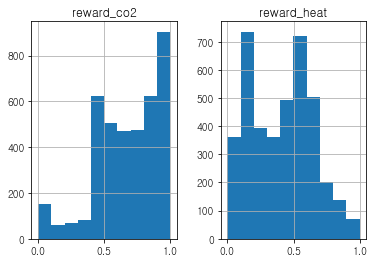

In [7]:
data_by_room[room_list[1]][['reward_co2','reward_heat']].hist()

CPU times: total: 266 ms
Wall time: 265 ms


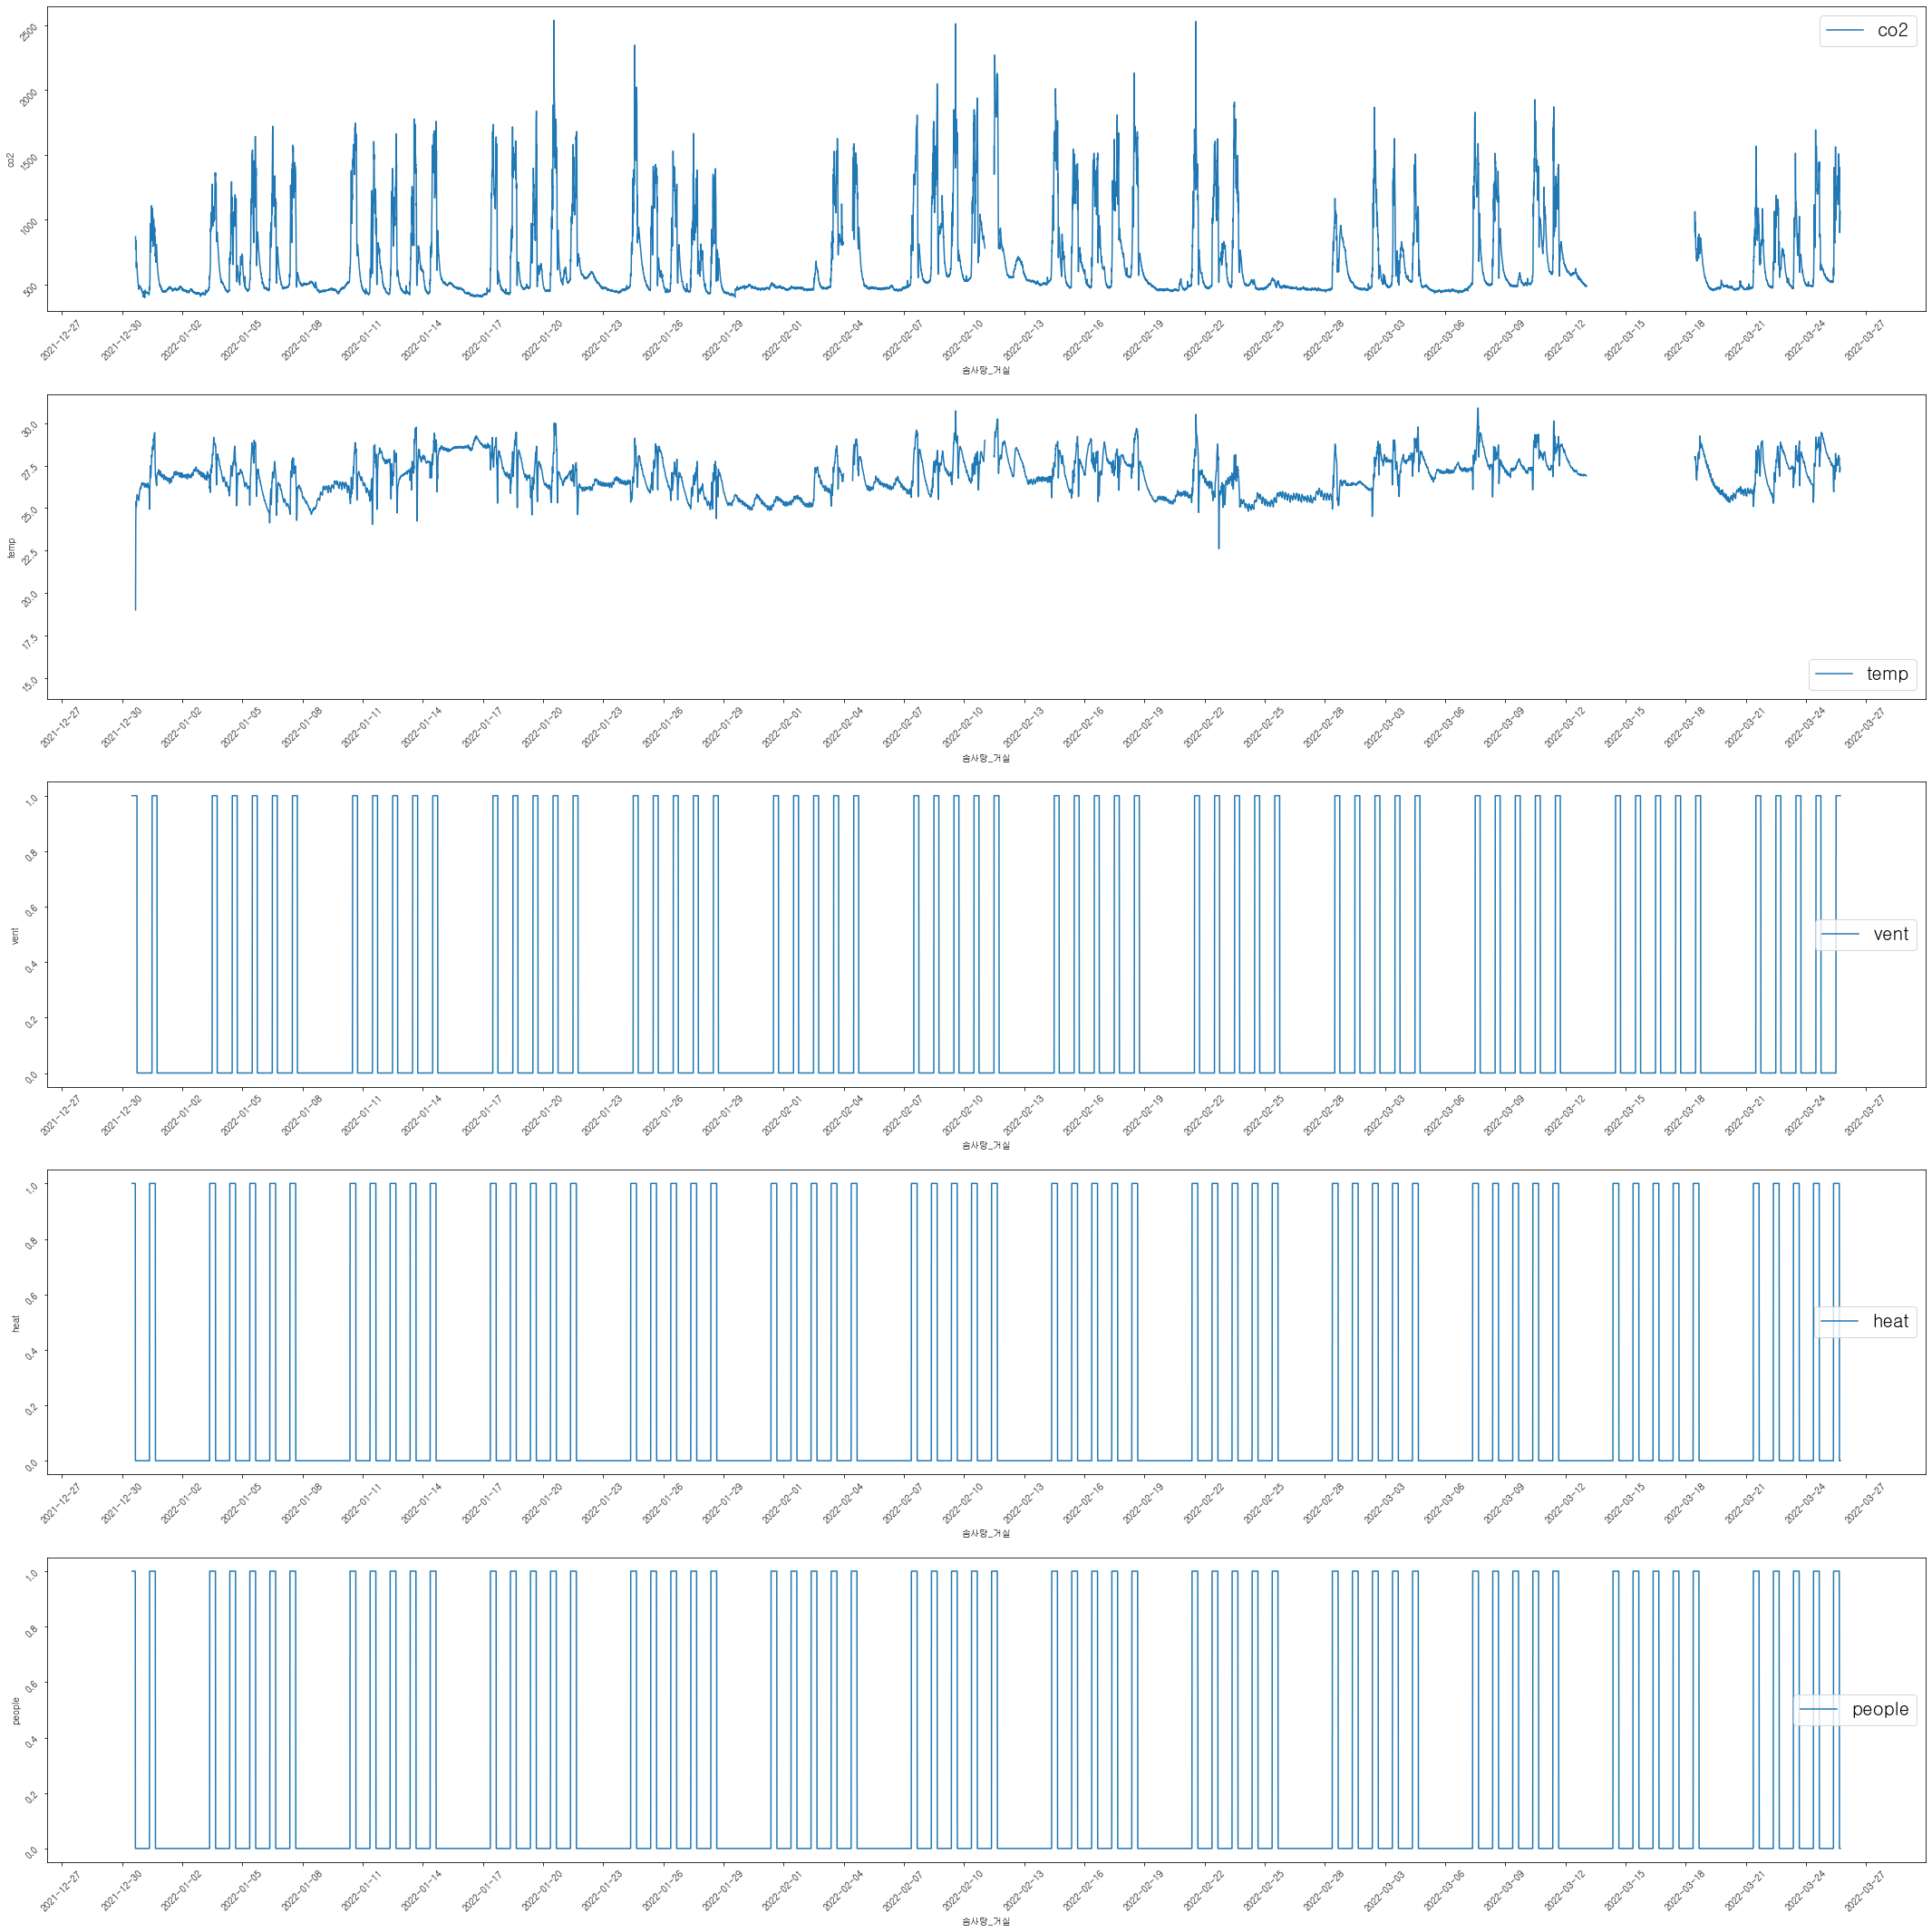

In [8]:
%%time
fig, axes = plt.subplots(5,1, figsize=(30,30))
# mean_by_date.loc[:,val].plot()
plt.rc('font', size=20)        # 기본 폰트 크기
# plt.rc('axes', labelsize=20)   # x,y축 label 폰트 크기
plt.rc('xtick', labelsize=15)  # x축 눈금 폰트 크기 
plt.rc('ytick', labelsize=20)  # y축 눈금 폰트 크기
plt.rc('legend', fontsize=20)  # 범례 폰트 크기
plt.rc('figure', titlesize=20)


p_data = data_by_room["솜사탕_거실.csv"]


axes[0].plot(p_data['co2'], label = 'co2')
axes[0].set_ylabel('co2')
axes[0].legend()
axes[0].set_xlabel("솜사탕_거실")
axes[0].tick_params(labelrotation=45)
axes[0].xaxis.set_major_locator(dates.DayLocator(interval=3,))

axes[1].plot(p_data['temp'], label = 'temp')
axes[1].set_ylabel('temp')
axes[1].legend()
axes[1].set_xlabel("솜사탕_거실")
axes[1].tick_params(labelrotation=45)
axes[1].xaxis.set_major_locator(dates.DayLocator(interval=3,))

axes[2].plot(p_data['vent'], label = 'vent')
axes[2].set_ylabel('vent')
axes[2].legend()
axes[2].set_xlabel("솜사탕_거실")
axes[2].tick_params(labelrotation=45)
axes[2].xaxis.set_major_locator(dates.DayLocator(interval=3,))

axes[3].plot(p_data['heat'], label = 'heat')
axes[3].set_ylabel('heat')
axes[3].legend()
axes[3].set_xlabel("솜사탕_거실")
axes[3].tick_params(labelrotation=45)
axes[3].xaxis.set_major_locator(dates.DayLocator(interval=3,))

axes[4].plot(p_data['people'], label = 'people')
axes[4].set_ylabel('people')
axes[4].legend()
axes[4].set_xlabel("솜사탕_거실")
axes[4].tick_params(labelrotation=45)
axes[4].xaxis.set_major_locator(dates.DayLocator(interval=3,))

fig.tight_layout()

CPU times: total: 125 ms
Wall time: 113 ms


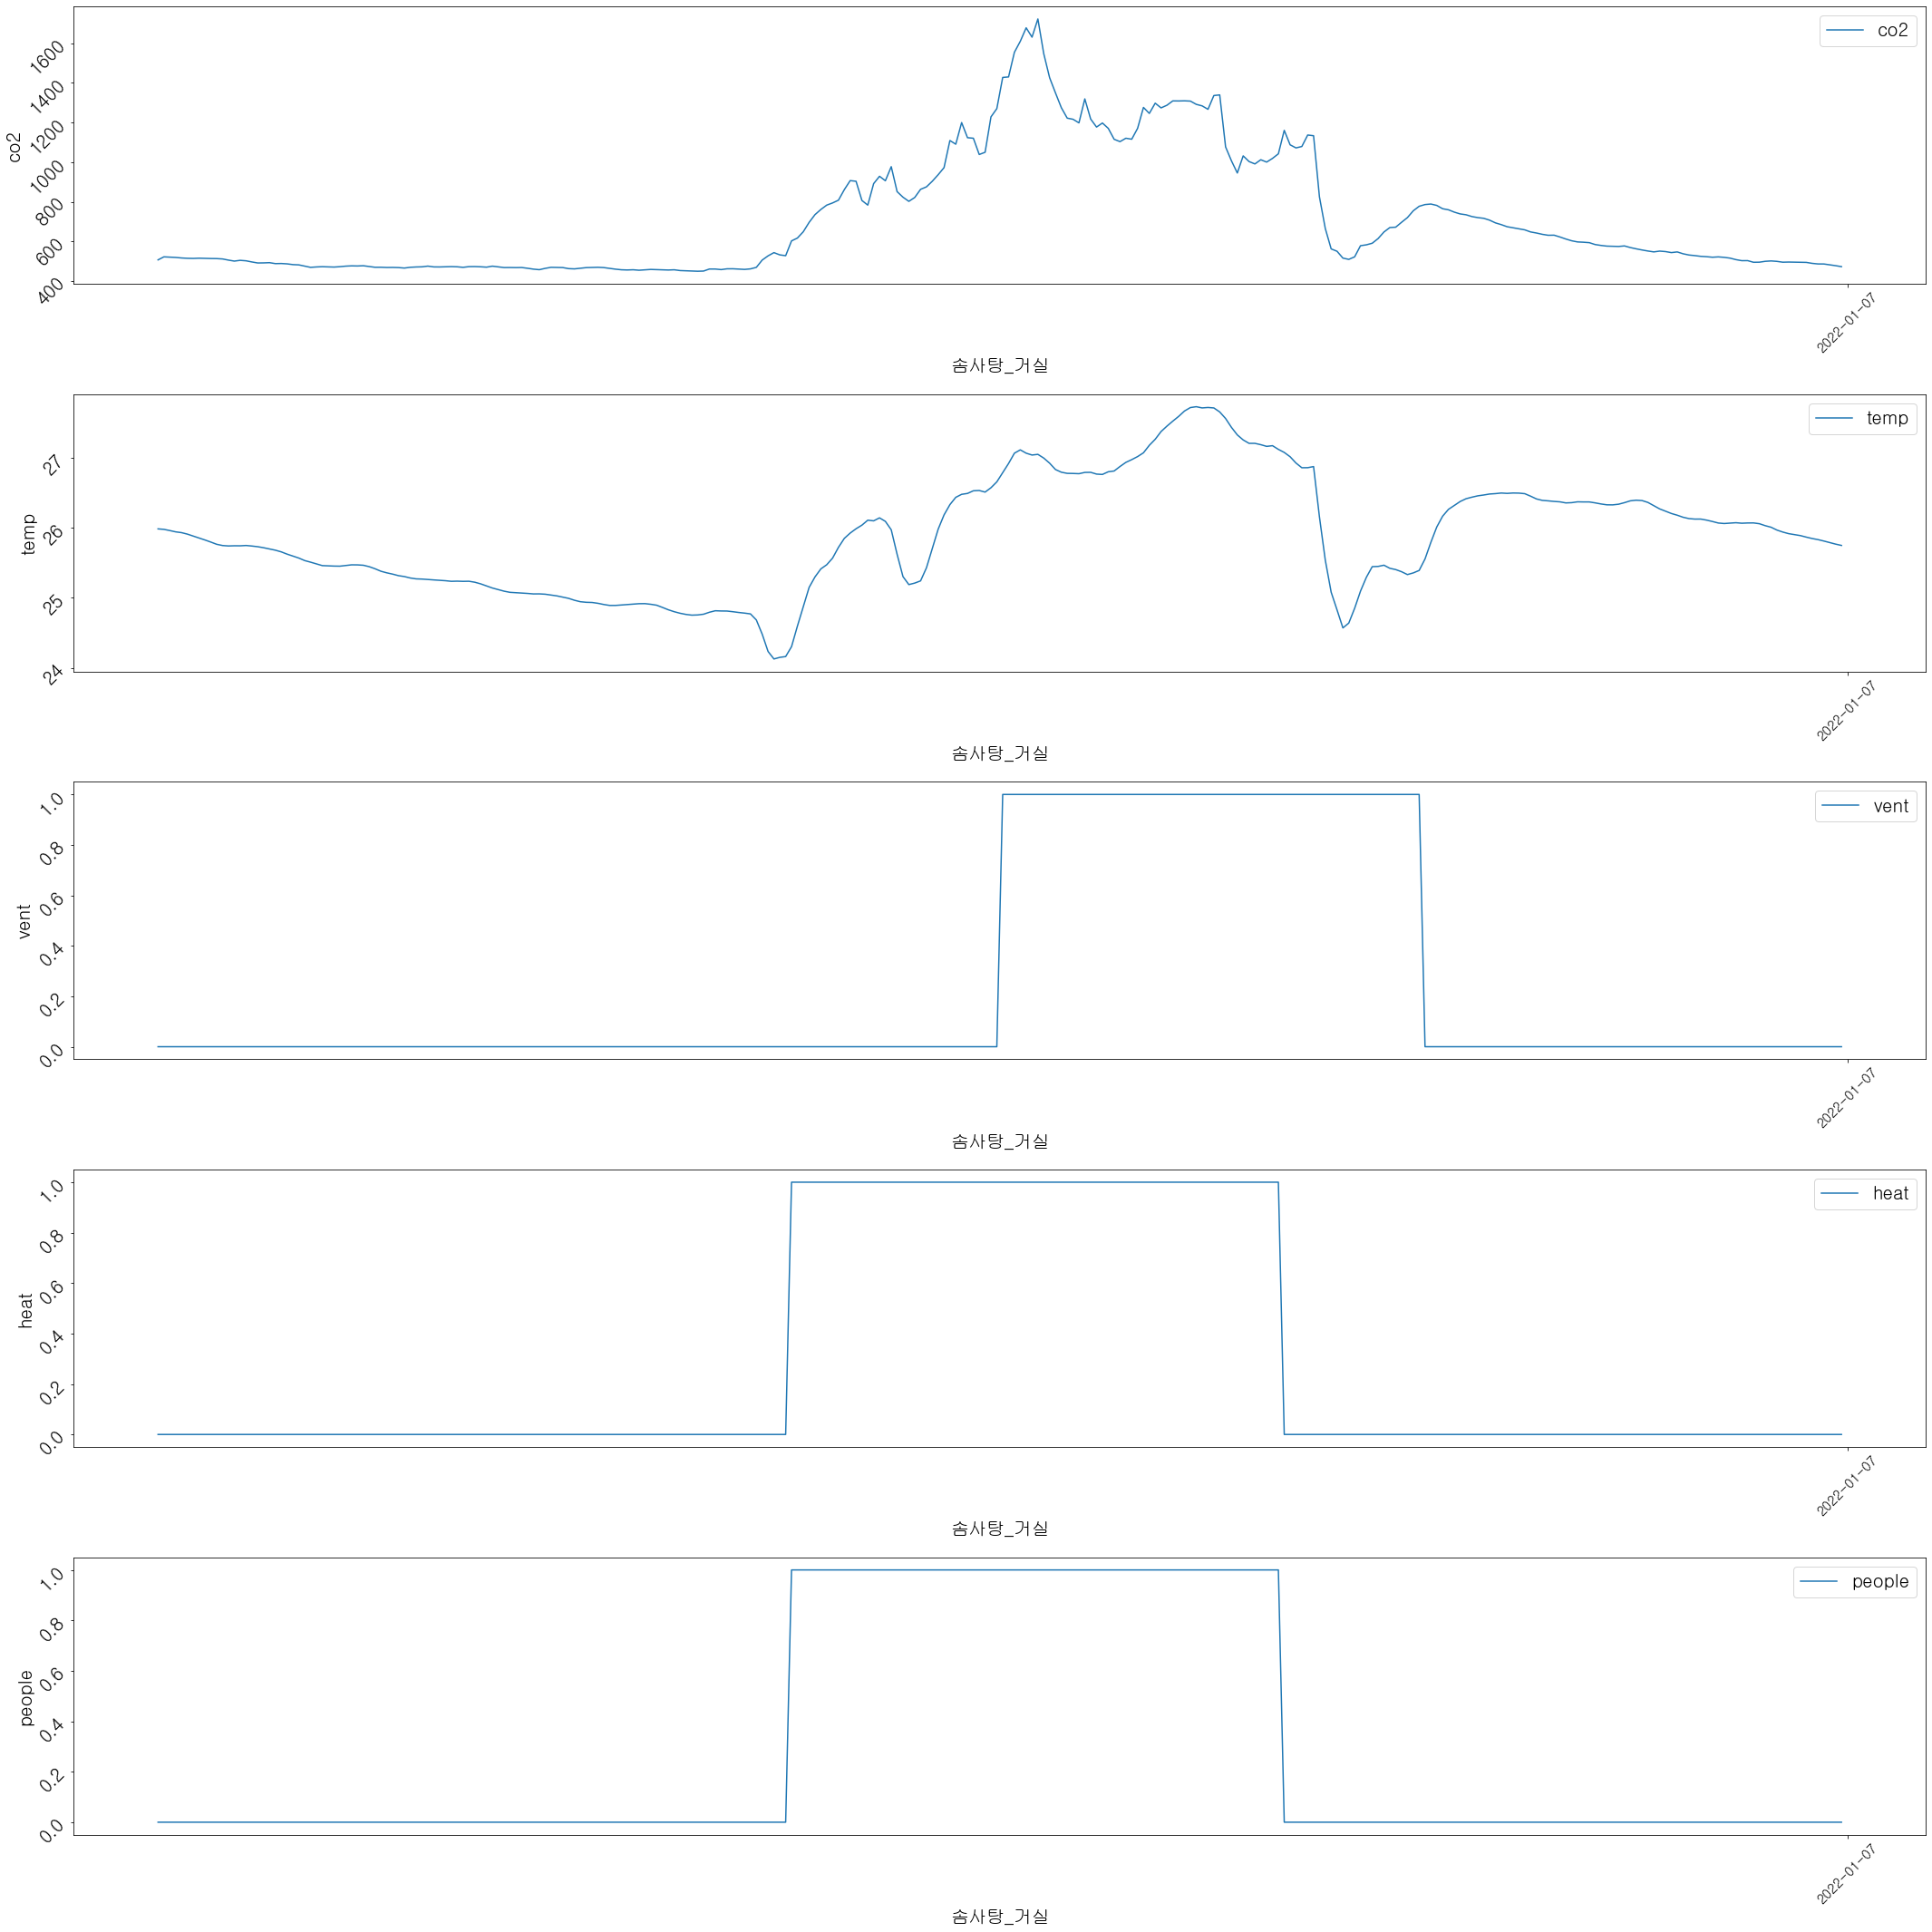

In [9]:
%%time
fig, axes = plt.subplots(5,1, figsize=(30,30))
# mean_by_date.loc[:,val].plot()
plt.rc('font', size=20)        # 기본 폰트 크기
# plt.rc('axes', labelsize=20)   # x,y축 label 폰트 크기
plt.rc('xtick', labelsize=15)  # x축 눈금 폰트 크기 
plt.rc('ytick', labelsize=20)  # y축 눈금 폰트 크기
plt.rc('legend', fontsize=20)  # 범례 폰트 크기
plt.rc('figure', titlesize=20)


p_data = data_by_room["솜사탕_거실.csv"].loc['2022-01-6':'2022-01-06']

axes[0].plot(p_data['co2'], label = 'co2')
axes[0].set_ylabel('co2')
axes[0].legend()
axes[0].set_xlabel("솜사탕_거실")
axes[0].tick_params(labelrotation=45)
axes[0].xaxis.set_major_locator(dates.DayLocator(interval=3,))

axes[1].plot(p_data['temp'], label = 'temp')
axes[1].set_ylabel('temp')
axes[1].legend()
axes[1].set_xlabel("솜사탕_거실")
axes[1].tick_params(labelrotation=45)
axes[1].xaxis.set_major_locator(dates.DayLocator(interval=3,))

axes[2].plot(p_data['vent'], label = 'vent')
axes[2].set_ylabel('vent')
axes[2].legend()
axes[2].set_xlabel("솜사탕_거실")
axes[2].tick_params(labelrotation=45)
axes[2].xaxis.set_major_locator(dates.DayLocator(interval=3,))

axes[3].plot(p_data['heat'], label = 'heat')
axes[3].set_ylabel('heat')
axes[3].legend()
axes[3].set_xlabel("솜사탕_거실")
axes[3].tick_params(labelrotation=45)
axes[3].xaxis.set_major_locator(dates.DayLocator(interval=3,))

axes[4].plot(p_data['people'], label = 'people')
axes[4].set_ylabel('people')
axes[4].legend()
axes[4].set_xlabel("솜사탕_거실")
axes[4].tick_params(labelrotation=45)
axes[4].xaxis.set_major_locator(dates.DayLocator(interval=3,))

fig.tight_layout()

* 멀티에이전트 학습용 함수

In [10]:
# dense model 만드는 함수
def make_dense_model(hidden_structure,input_shape,act_function,output_shape):
    inputs = tf.keras.Input(shape=input_shape)
    
    for i, val in enumerate(hidden_structure):
        n_percep = val 
        if i == 0:
            x = keras.layers.Dense(n_percep, activation= act_function)(inputs)

        elif  i != 0 and i != len(hidden_structure)-1:
            x = keras.layers.Dense(n_percep, activation= act_function)(x)

        elif  i == len(hidden_structure)-1:
            x = keras.layers.Dense(n_percep,activation= act_function)(x)
    x = keras.layers.Dense(output_shape)(x)

    dense_model = tf.keras.Model(inputs=inputs, outputs=x)
    return dense_model

# multi_agent structure 만드는 함수
def build_structure(agent_num, hidden_structure,input_shape,act_function,output_shape):
    actor_list = []
    critic_qnet_list = []
    critic_qnet_target_list = []
    for i in range(agent_num):
        actor_list.append(make_dense_model(hidden_structure,input_shape,act_function,output_shape))
        critic_qnet_list.append(make_dense_model(hidden_structure,input_shape,act_function,output_shape))
        critic_qnet_target_list.append(make_dense_model(hidden_structure,input_shape,act_function,output_shape))
    return actor_list, critic_qnet_list, critic_qnet_target_list


def get_action(actor,state, num_samples: int = 3):
    logit_sam = actor(state)
    m = tfp.distributions.Categorical(logits = logit_sam)
    return tf.reshape(m.sample(num_samples),[-1,num_samples])

def get_mean_qsa(qs,sampled_as):
    
    mean_q = tf.concat([tf.reshape(tf.gather(qs[i],sampled_as[i], axis=0),[1,-1]) for i in range(len(qs))],axis=0)
    mean_q = tf.math.reduce_mean(mean_q,axis=1,keepdims=True)
    return mean_q

* 학습데이터셋 전처리

In [11]:
room_sync_list = ['솜사탕_거실.csv']
# room_sync_list = ['솜사탕_거실.csv', '솜사탕_거실.csv', '솜사탕_거실.csv', '솜사탕_거실.csv']
# room_sync_list = ['솜사탕_거실.csv', '솜사탕_방2.csv']

s = []
ns = []
a_list = []
r_list = []

start_date = '2022-01-04'
end_date = '2022-01-27'

len_list = []
for i in room_sync_list:
    temp_data = data_by_room[i].loc[start_date:end_date]
    len_notna = len(temp_data.dropna())
    len_list.append(len_notna)
max_na_room = room_sync_list[np.argmin(len_list)]
row_ind = data_by_room[max_na_room].loc[start_date:end_date].dropna().index




temp_data = data_by_room[i].loc[row_ind]

s.append(tf.convert_to_tensor(temp_data.values[:,[0,1,2],],dtype=tf.float32))
ns.append(tf.convert_to_tensor(temp_data.values[:,[3,4,5],],dtype=tf.float32))

a_list.append(tf.convert_to_tensor(temp_data.values[:,[8],],dtype=tf.int64))
a_list.append(tf.convert_to_tensor(temp_data.values[:,[9],],dtype=tf.int64))


r_list.append(tf.convert_to_tensor(temp_data.values[:,[6],],dtype=tf.float32))
r_list.append(tf.convert_to_tensor(temp_data.values[:,[7],],dtype=tf.float32))

print(temp_data.isna().sum())
#정규화 레이어
layer = tf.keras.layers.Normalization(axis=1)
layer.adapt(s[0])

#데이터셋 제작
s_dataset = tf.data.Dataset.from_tensor_slices(layer(s[0]))
ns_dataset = tf.data.Dataset.from_tensor_slices(layer(ns[0]))

a1_dataset = tf.data.Dataset.from_tensor_slices(a_list[0])
a2_dataset = tf.data.Dataset.from_tensor_slices(a_list[1])

r1_dataset = tf.data.Dataset.from_tensor_slices(r_list[0])
r2_dataset = tf.data.Dataset.from_tensor_slices(r_list[1])

done_dataset = tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(data_by_room[i].loc[start_date:end_date].values[:,[10]],dtype=tf.float32))

train_dataset = tf.data.Dataset.zip((s_dataset, ns_dataset, ((a1_dataset,r1_dataset),(a2_dataset,r2_dataset),),done_dataset))
train_dataset.element_spec


co2            0
temp           0
people         0
co2_t+1        0
temp_t+1       0
people_t+1     0
reward_co2     0
reward_heat    0
vent           0
heat           0
done           0
dtype: int64


(TensorSpec(shape=(3,), dtype=tf.float32, name=None),
 TensorSpec(shape=(3,), dtype=tf.float32, name=None),
 ((TensorSpec(shape=(1,), dtype=tf.int64, name=None),
   TensorSpec(shape=(1,), dtype=tf.float32, name=None)),
  (TensorSpec(shape=(1,), dtype=tf.int64, name=None),
   TensorSpec(shape=(1,), dtype=tf.float32, name=None))),
 TensorSpec(shape=(1,), dtype=tf.float32, name=None))

In [51]:
temp_data

,co2,temp,people,co2_t+1,temp_t+1,people_t+1,reward_co2,reward_heat,vent,heat,done,testset_a_vent,testset_a_heat
T/D,,,,,,,,,,,,,
2022-02-21 00:00:00,457.490800,25.769233,0,453.658933,25.728133,0.0,0.443462,0.262333,0,0,True,1,0
2022-02-21 00:05:00,453.658933,25.728133,0,453.214767,25.700967,0.0,0.442744,0.256545,0,0,False,1,0
2022-02-21 00:10:00,453.214767,25.700967,0,457.630133,25.695367,0.0,0.449896,0.255361,0,0,False,1,0
2022-02-21 00:15:00,457.630133,25.695367,0,464.027200,25.709033,0.0,0.460333,0.258255,0,0,False,1,0
2022-02-21 00:20:00,464.027200,25.709033,0,462.052767,25.752100,0.0,0.457102,0.267508,0,0,False,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-24 23:35:00,465.628733,25.292267,0,466.041267,25.291000,0.0,0.463637,0.179140,0,0,False,1,0
2022-02-24 23:40:00,466.041267,25.291000,0,468.392467,25.283367,0.0,0.467504,0.177876,0,0,False,1,0
2022-02-24 23:45:00,468.392467,25.283367,0,468.702400,25.280600,0.0,0.468015,0.177419,0,0,False,1,0


* 모델 학습

In [46]:
%%time
#################set params!################
# params of multi_AWAC
agent_num = 2
state_len = 3
hidden_structure= [64, 128, 256, 128, 64]
input_shape= 3
output_shape= 2
act_function= 'relu'
lam = 10
optimizer= keras.optimizers.Adam(learning_rate=3 * 1e-5)
gamma= 0.9
tau = 0.1
num_action_samples = 8
loss_fun = tf.keras.losses.MeanSquaredError()

# 학습 루프 관련
batch_size = 256
buffer_len = len(train_dataset)
# n_train = 10
n_run = 10
############################################
# 초기 모델 생성
actor_list, critic_qnet_list, critic_qnet_target_list = build_structure(agent_num, hidden_structure,input_shape,act_function,output_shape)


#배치셋 생성
# batched_dataset = train_dataset.shuffle(buffer_size=buffer_len).batch(batch_size, drop_remainder=True)
shuffled_dataset = train_dataset.shuffle(buffer_size=buffer_len)

# 트레인 루프
# for batch in batched_dataset.take(n_train):
critic_loss = []
actor_loss_1 = []
actor_loss_2 = []

count = 0
for batch in shuffled_dataset.batch(batch_size).take(1).repeat(n_run):
    count += 1
    if count % 10 == 0:
        print(f"-run- [{count}]/[{n_run}]")
    

    with tf.GradientTape() as t:
        loss_list =[]
        for j in range(agent_num):
            ##데이터 
            s = batch[0]
            ns = batch[1]
            a = batch[2][j][0]
            r = batch[2][j][1]
            done = batch[3]
            ##에이전트
            actor = actor_list[j]
            critic_qnet = critic_qnet_list[j]
            critic_qnet_target = critic_qnet_target_list[j]
            ##로스 계산
            qs = critic_qnet_target(ns)
            sampled_as = get_action(actor,ns, num_action_samples)
            mean_qsa = get_mean_qsa(qs,sampled_as)
            q_target = r + gamma * mean_qsa * (1 - done)

            # 식 3에서 봤던 것처럼 mse형태로 로스함수 설정
            q_val = tf.concat([tf.reshape(tf.gather(critic_qnet(s)[k],a[k],axis=0),[-1,1]) for k in range(len(s))],axis=0)
            loss = loss_fun(q_val, q_target)
            loss_list.append(loss)
        joint_loss = tf.math.reduce_mean(loss_list, axis=None, keepdims=False, name=None)
        
        critic_loss.append(joint_loss)

    critic_qnet_weight_list = [critic_qnet_list[p].trainable_variables for p in range(agent_num)]
    critic_qnet_target_weight_list = [critic_qnet_target_list[p].trainable_variables for p in range(agent_num)]
    grads = t.gradient(joint_loss, critic_qnet_weight_list)

    for q in range(agent_num):
        # qnet 업데이트
        qnet_weights = critic_qnet_weight_list[q]
        qnet_target_weights = critic_qnet_target_weight_list[q]
        grad = grads[q]

        optimizer.apply_gradients(zip(grad, qnet_weights))
        # target net 업데이트
        new_target_weights = []
        for p, target_weights in enumerate(qnet_target_weights):
            qnet_weights_s = qnet_weights[p]
            updated_target_weights_s = target_weights*(1 - tau) + qnet_weights_s*tau
            new_target_weights.append(updated_target_weights_s)
        critic_qnet_target_list[q].set_weights(new_target_weights)

        #타겟네트워크까지 업데이트한 후 actor net 업데이트
        with tf.GradientTape() as tp:
            # log_probability 계산
            logits = actor_list[q](s)
            m = tfp.distributions.Categorical(logits = logits)
            log_prob = tf.reshape(m.log_prob(a.numpy().squeeze()),[-1,1])

            #가중치항 계산
            qs = critic_qnet_target_list[q](s)
            action_probs = tf.nn.softmax(logits, axis=None, name=None)
            vs = tf.math.reduce_sum((qs * action_probs),axis=1, keepdims=True, name=None)
            qas = tf.concat([tf.reshape(tf.gather(qs[k],a[k],axis=0),[-1,1]) for k in range(len(s))],axis=0)
            adv = qas - vs
            weight_term = tf.math.exp((1/lam*adv), name=None)
            
            

            #loss
            loss = tf.math.reduce_mean(log_prob * weight_term*-1)
            
            if q == 0 :
                actor_loss_1.append(loss)
            elif q == 1 :
                actor_loss_2.append(loss)
            
        actor_grad = tp.gradient(loss, actor_list[q].trainable_variables)
        
        optimizer.apply_gradients(zip(actor_grad, actor_list[q].trainable_variables))
    

-run- [10]/[10]
CPU times: total: 1min 3s
Wall time: 1min 20s


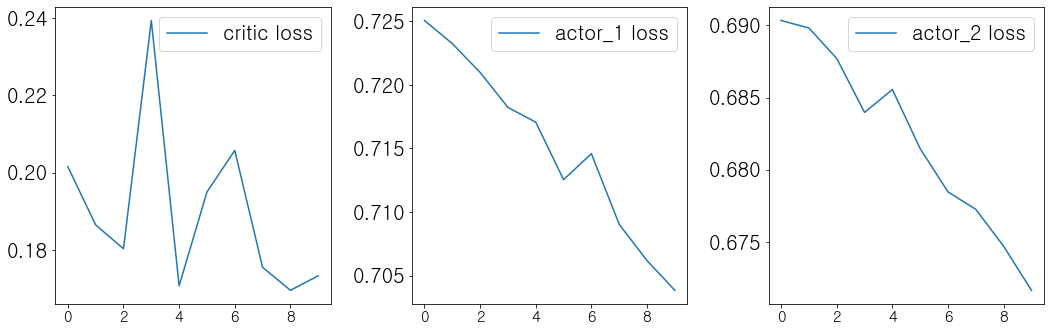

In [47]:
fig, axes = plt.subplots(1,3, figsize=(15,5))
axes[0].plot(critic_loss, label='critic loss')
axes[0].legend()
axes[1].plot(actor_loss_1, label='actor_1 loss')
axes[1].legend()
axes[2].plot(actor_loss_2, label='actor_2 loss')
axes[2].legend()
# axes[2].hist(cum_rs, density=True, label='expert')
# axes[2].legend()
# axes[2].hist(awac_cum_rs, 
#          alpha=0.5, 
#          density=True, label='offline')
# axes[2].legend()
fig.tight_layout()

* 테스트셋에 테스트

In [48]:
room_sync_list = ['솜사탕_거실.csv']


s = []

start_date = '2022-02-21'
end_date = '2022-02-24'

len_list = []
for i in room_sync_list:
    temp_data = data_by_room[i].loc[start_date:end_date]
    len_notna = len(temp_data.dropna())
    len_list.append(len_notna)
max_na_room = room_sync_list[np.argmin(len_list)]
row_ind = data_by_room[max_na_room].loc[start_date:end_date].dropna().index


# attention state set 제작
test_action_set_list = []

temp_data = data_by_room['솜사탕_거실.csv'].loc[row_ind]
test_action_set_list.append(temp_data)
s.append(layer(tf.convert_to_tensor(temp_data.values[:,[0,1,2],],dtype=tf.float32)))
    
    

s = tf.concat(s,axis=1)

# state-action set 제작

testset_action = actor_list[0](s)
test_action_set_list[0]['testset_a_vent'] = tf.math.argmax(testset_action,axis=1,output_type=tf.dtypes.int64,name=None).numpy()

testset_action = actor_list[1](s)
test_action_set_list[0]['testset_a_heat'] = tf.math.argmax(testset_action,axis=1,output_type=tf.dtypes.int64,name=None).numpy()
    


array([[<AxesSubplot:title={'center':'0'}>,
        <AxesSubplot:title={'center':'1'}>],
       [<AxesSubplot:title={'center':'2'}>, <AxesSubplot:>]], dtype=object)

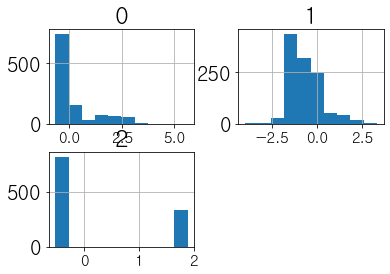

In [49]:
pd.DataFrame(s.numpy()).hist()

CPU times: total: 125 ms
Wall time: 126 ms


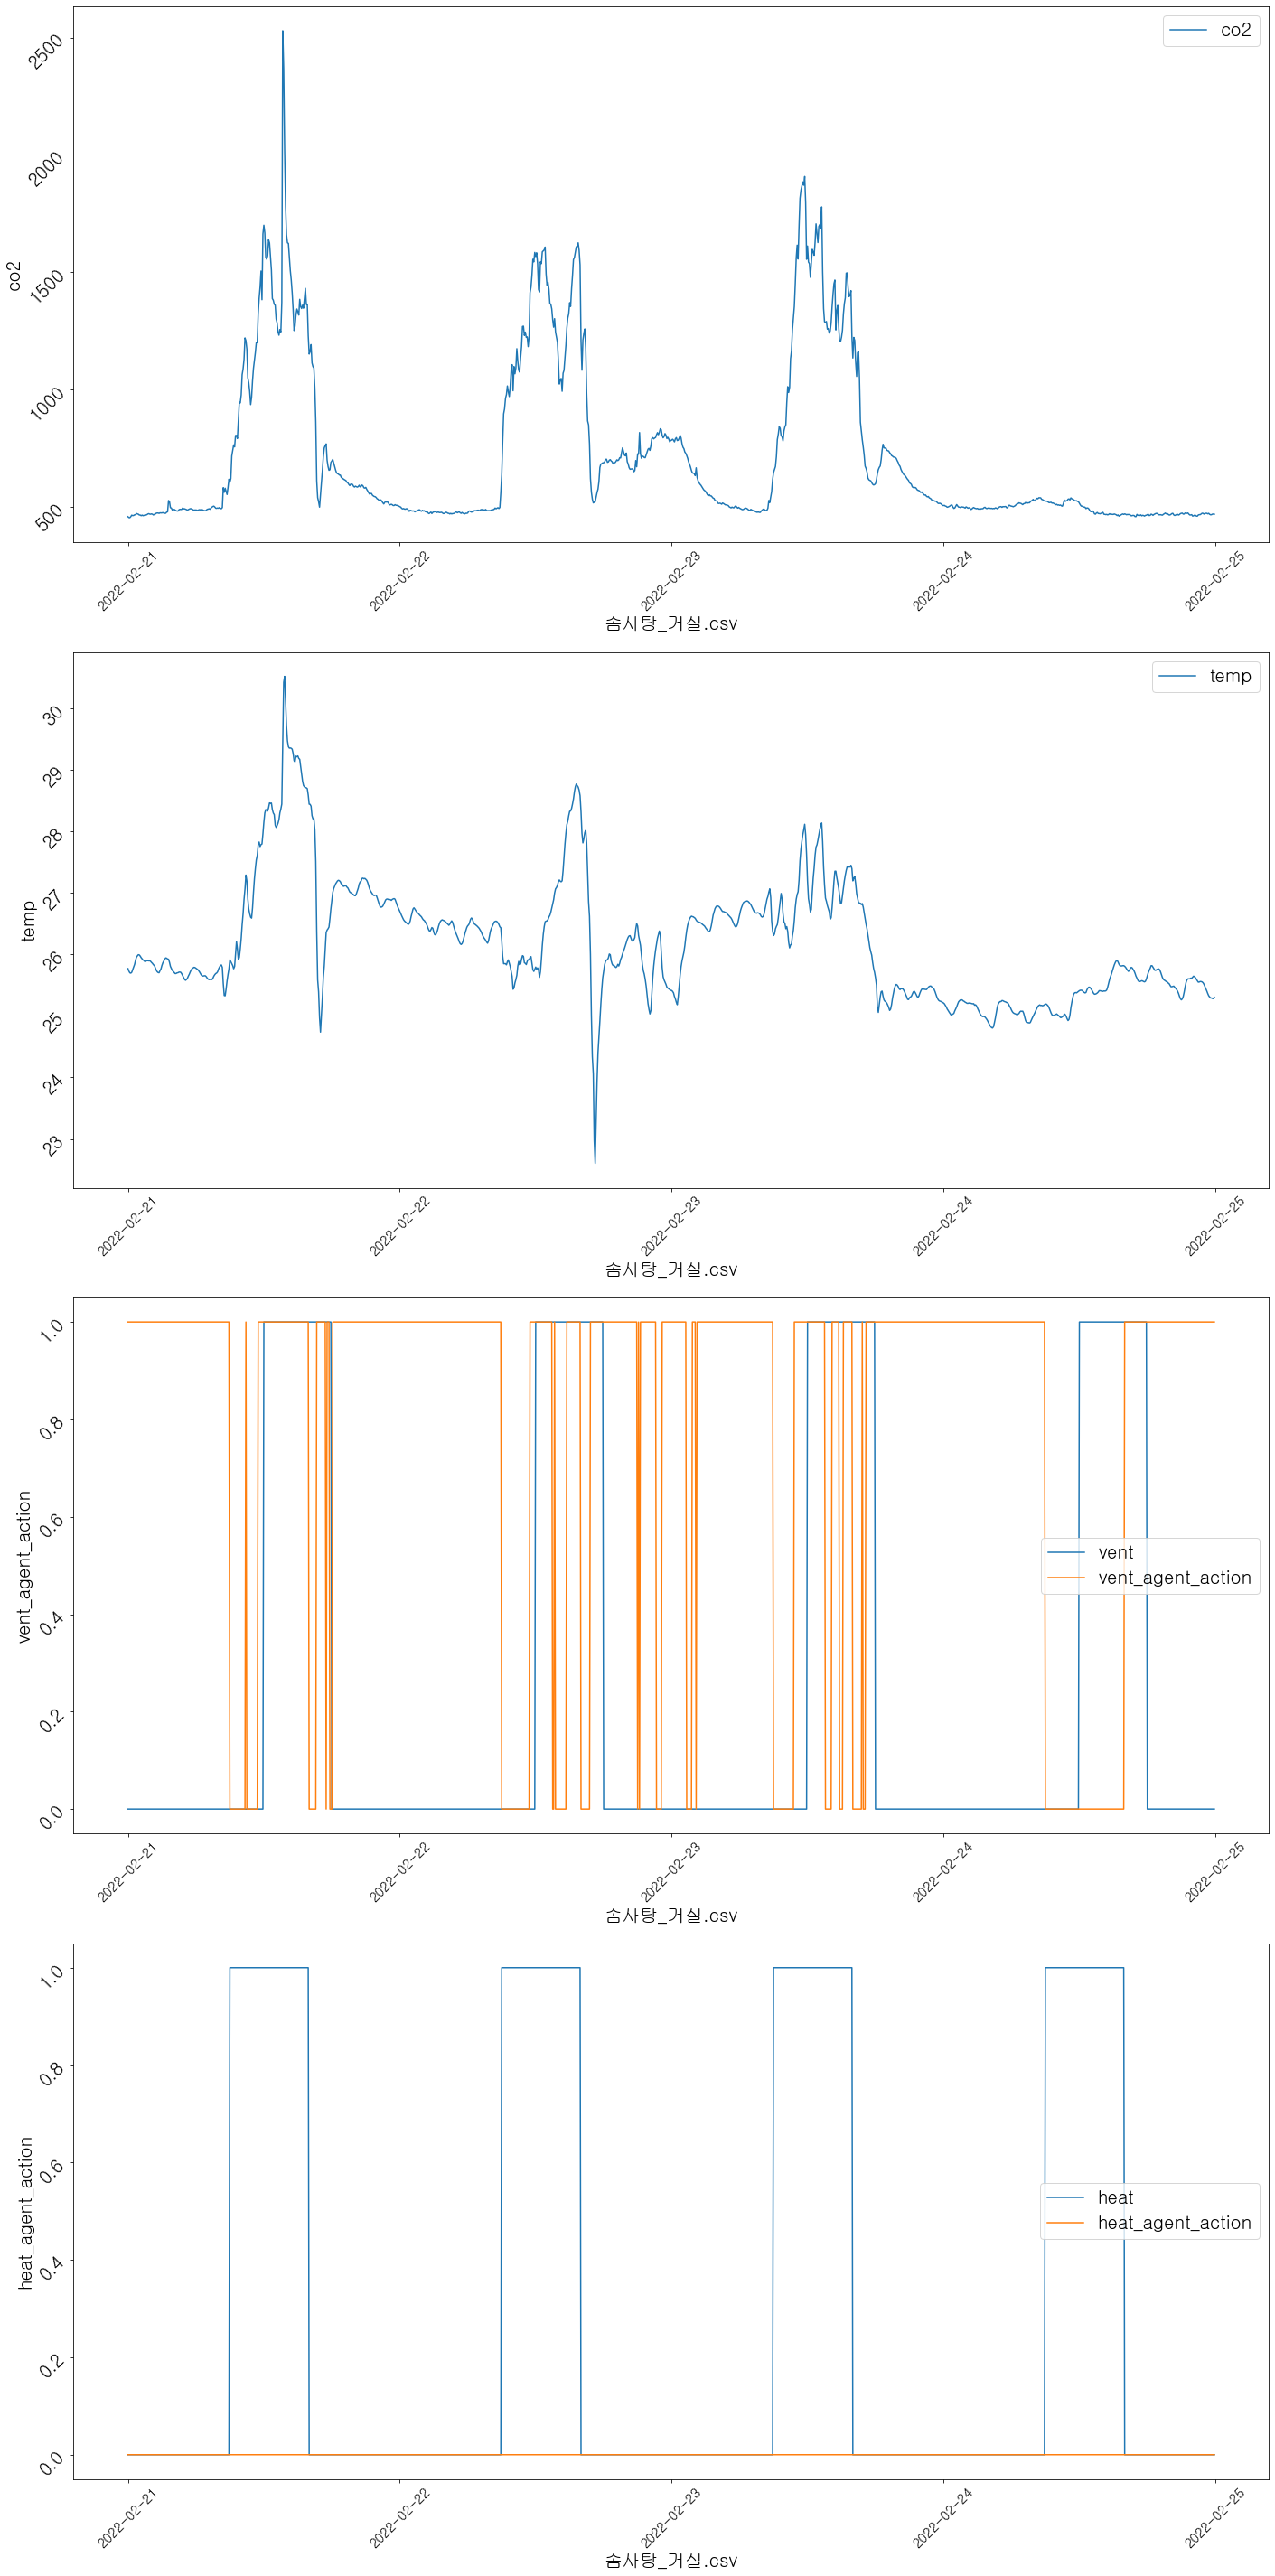

In [50]:
%%time
fig, axes = plt.subplots(len(room_sync_list)*4,1, figsize=(20,40))
# mean_by_date.loc[:,val].plot()
plt.rc('font', size=20)        # 기본 폰트 크기
# plt.rc('axes', labelsize=20)   # x,y축 label 폰트 크기
plt.rc('xtick', labelsize=15)  # x축 눈금 폰트 크기 
plt.rc('ytick', labelsize=20)  # y축 눈금 폰트 크기
plt.rc('legend', fontsize=20)  # 범례 폰트 크기
plt.rc('figure', titlesize=20)

for i, val in enumerate(room_sync_list):
    p_data = test_action_set_list[i]

    axes[i*3].plot(p_data.loc[:,'co2'], label = 'co2')
    axes[i*3].set_ylabel('co2')
    axes[i*3].legend()
    axes[i*3].set_xlabel(val)
    axes[i*3].tick_params(labelrotation=45)
    axes[i*3].xaxis.set_major_locator(dates.DayLocator())

    axes[1+i*3].plot(p_data.loc[:,'temp'], label = 'temp')
    axes[1+i*3].set_ylabel('temp')
    axes[1+i*3].legend()
    axes[1+i*3].set_xlabel(val)
    axes[1+i*3].tick_params(labelrotation=45)
    axes[1+i*3].xaxis.set_major_locator(dates.DayLocator())

    axes[2+i*3].plot(p_data.loc[:,'vent'], label = 'vent')
    axes[2+i*3].set_ylabel('vent')
    axes[2+i*3].legend()
    axes[2+i*3].set_xlabel(val)
    axes[2+i*3].tick_params(labelrotation=45)
    axes[2+i*3].xaxis.set_major_locator(dates.DayLocator())

    axes[2+i*3].plot(p_data.loc[:,'testset_a_vent'], label = 'vent_agent_action')
    axes[2+i*3].set_ylabel('vent_agent_action')
    axes[2+i*3].legend()
    axes[2+i*3].set_xlabel(val)
    axes[2+i*3].tick_params(labelrotation=45)
    axes[2+i*3].xaxis.set_major_locator(dates.DayLocator())

    axes[3+i*3].plot(p_data.loc[:,'heat'], label = 'heat')
    axes[3+i*3].set_ylabel('heat')
    axes[3+i*3].legend()
    axes[3+i*3].set_xlabel(val)
    axes[3+i*3].tick_params(labelrotation=45)
    axes[3+i*3].xaxis.set_major_locator(dates.DayLocator())

    axes[3+i*3].plot(p_data.loc[:,'testset_a_heat'], label = 'heat_agent_action')
    axes[3+i*3].set_ylabel('heat_agent_action')
    axes[3+i*3].legend()
    axes[3+i*3].set_xlabel(val)
    axes[3+i*3].tick_params(labelrotation=45)
    axes[3+i*3].xaxis.set_major_locator(dates.DayLocator())

plt.tight_layout()